### Transcriptomics analysis

In [30]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as CPTAC

In [20]:
gene = 'TP53'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
transcriptomics = CPTAC.get_transcriptomics()

hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.241del','p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']

mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]

# Get a list of patient identifiers for those who have mutations in the hotspot
hotspot_patients_both_keys = mutated_hotspot[['Clinical_Patient_Key', 'Patient_Id']]
hotspot_patients = hotspot_patients_both_keys['Clinical_Patient_Key']

In [21]:
interProtList = ['AIMP2', 'ARIH2', 'ARRB1', 'ASH2L', 'ATG7', 'AXIN1', 'BANP', 'BCL2', 'BCL2L1', 'BCR', 'BHLHE40', 'BRCA2',
           'BRD7', 'BTBD2', 'BTRC', 'CABLES1', 'CARM1', 'CCDC106', 'CDKN1A', 'CEBPB', 'CHD8', 'CREBBP', 'CSE1L', 'CSNK2A1', 'CUL7',
           'CUL9', 'CXXC1', 'DAXX', 'DDX17', 'DDX5', 'DROSHA', 'DUSP26', 'DVL2', 'E6', 'EP300', 'ETS2', 'FBXO11',
           'FOXO3', 'GSK3B', 'GTF2H1', 'HDAC1', 'HIPK1', 'HIPK2', 'HMGB1', 'HNRNPK', 'HRMT1L2', 'HSP82', 'HSPA1L', 'HSPA9', 'HSPB1',
           'HTT', 'HUWE1', 'IFI16', 'IFI205B', 'ING4', 'IKBKB', 'IP6K2', 'JMJD6', 'KAT5', 'KAT8', 'KDM1A', 'KMT2E', 'LAMA4',
           'MAGEA2B', 'MAGEC2', 'MAP1B', 'MAPK11', 'MAPKAPK5', 'MDM2', 'MDM4', 'MKRN1', 'MPDZ', 'MT1A', 'NCL', 'NCOR2',
           'NFYA', 'NFYB', 'NOC2L', 'NOL3', 'NPM1', 'NR0B2', 'NR4A1', 'NRDC', 'NSP1', 'NUAK1', 'NUMB', 'OTUB1', 
           'PARD3', 'PARP1', 'PBK', 'PHB', 'PIAS1', 'PIAS2', 'PIAS4', 'PIN1', 'PLK1', 'PML', 'PPIF', 'PPP1CC',
           'PPP1R13L', 'PPP2R1A', 'PPP2R5C', 'PRKCD', 'PSME3', 'PTK2', 'RAD51', 'RBPJ', 'RCHY1', 'RFWD3', 'RING1',
           'RPS3', 'RYBP', 'S100A1', 'S100A2', 'S100A4', 'S100B', 'SAFB', 'SETD7', 'SFN', 'SIN3A', 'SIRT1', 'SMAD2',
           'SMYD2', 'SNAT1', 'SOX4', 'SP1', 'SREBF2', 'SRPK1', 'SUMO1', 'SYVN1', 'TAF1', 'TBP', 'TCF4', 'TOE1', 'TP53BP1',
           'TP53BP2', 'TP53INP1', 'TP63', 'TPT1', 'TRIM24', 'TWIST1', 'UBC', 'UBE3A', 'UHRF2', 'USP42', 'USP7', 'VDR', 'VRK1',
           'WRN', 'WWOX', 'XPO1', 'XRCC6', 'YWHAG', 'YWHAZ', 'ZNF420', 'ATM', 'BAX', 'BCL2L11', 'CCNA1', 'CCNA2', 'CCNB1', 
           'CCNB2', 'CCND1', 'CCND3', 'CCNE1', 'CCNE2', 'CDC25A', 'CDC6', 'CDK2', 'CDKN1B', 'CDKN2A', 'CHEK1', 
           'CHEK2', 'CITED2', 'CKS1B', 'MCM5', 'MRE11A', 'PCNA', 'RB1', 'ARMC10', 'BANP', 'CDKN2AIP', 'NUAK1', 'STK11',
           'LKB1', 'UHRF2', 'E4F1', 'MAML1', 'MKRN1', 'PML', 'FBXO42', 'ATM', 'PP2A', 'PPP2R5C', 'PPP2R2A', 'AURKA', 'DAXX',
           'BRD7', 'TRIM24', 'L3MBTL1', 'GRK5', 'CAK', 'CDK7', 'MAT1', 'CDK5', 'AURKB', 'SETD2', 'UHRF2', 'NOC2L', 'PTK2',
           'FAK1', 'PTK2B', 'PYK2', 'PRKCG', 'PPIF', 'SNAI1', 'KAT6A', 'ANKRD2', 'RFFL', 'RNF34', 'MTA1', 'COP1', 'CCAR2',
           'MORC3', 'POU4F2', 'NOP53', 'AFG1L', 'UBD', 'TAF6', 'FATS', 'C10ORF90']
duplicate_len = len(interProtList)
interProtList = np.array(interProtList)
interProtList = np.unique(interProtList)
unique_len = len(interProtList)
interProtList = interProtList.tolist()
print(duplicate_len)
print(unique_len)

231
217


In [23]:
significant_all_mut_wt = {}
# Bonferroni correction of p-value significance cutoff to account for multiple hypothesis testing
pcutoff = 0.05 / len(interProtList)

for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in transcriptomics.columns:
        # Create dataframe with mutation status of TP53 with transcriptomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(transcriptomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest
        mutated_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
        wt_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated_tp53[protein], wt_tp53[protein])
        if ttest[1] <= pcutoff:
            significant_all_mut_wt[protein] = ttest[1]
significant_all_mut_wt

{'AURKA': 7.300141036395562e-08,
 'AURKB': 0.00022661849972699778,
 'BTRC': 3.347531106180032e-06,
 'CCNE1': 9.019908496545707e-05,
 'CDC25A': 0.00016642617077871098,
 'CDK2': 0.00010414872589130397,
 'CDKN1A': 2.2053510850046728e-07,
 'CHD8': 2.5320285904248184e-05,
 'CKS1B': 1.4617755106850618e-07,
 'CSE1L': 5.324096331932481e-07,
 'CSNK2A1': 5.721539774637132e-09,
 'DAXX': 2.831277646619219e-07,
 'DDX17': 7.762168076889267e-05,
 'GSK3B': 0.00018309261945878192,
 'MAGEC2': 3.712143251579257e-06,
 'MDM2': 9.181411547244045e-10,
 'NOC2L': 4.095532899221625e-05,
 'PLK1': 2.9140776028902155e-05,
 'RB1': 6.301574522112501e-05,
 'SETD7': 4.090389714609587e-05,
 'TPT1': 1.6877872265140266e-05,
 'XPO1': 3.329002514864271e-05,
 'YWHAZ': 2.9837215786961383e-06}

In [25]:
significant_nonhtspt_wt = {}
pcutoff = 0.05 / len(interProtList)

for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in transcriptomics.columns:
        p53_mutations_protein = CPTAC.compare_mutations(transcriptomics, protein, gene)
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == False]
        wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if ttest[1] <= pcutoff:
            significant_nonhtspt_wt[protein] = ttest[1]
            
significant_nonhtspt_wt

{'BTRC': 4.26251911261265e-06,
 'CHD8': 1.7666328842484176e-06,
 'CKS1B': 4.7332626537880164e-05,
 'CSNK2A1': 1.3374515491125868e-07,
 'DAXX': 1.2039677150945301e-05,
 'MAGEC2': 9.152223132505887e-06,
 'MDM2': 1.1042725578263574e-05,
 'RB1': 4.116223054918927e-05,
 'SETD7': 0.00010483698764916876,
 'TPT1': 4.9365692547696185e-05,
 'YWHAZ': 2.7163198815359843e-05}

In [37]:
significant_htspt_wt = {}
# Bonferroni correction of p-value significance cutoff to account for multiple hypothesis testing
pcutoff = 0.05 / len(interProtList)

for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in transcriptomics.columns:
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(transcriptomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest
        hotspot_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
        other_mut_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(hotspot_tp53) < 2 or len(other_mut_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(hotspot_tp53[protein], other_mut_tp53[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            significant_htspt_wt[protein] = ttest[1]
significant_htspt_wt

ANKRD2Ttest_indResult(statistic=4.249638904641884, pvalue=5.686486202447869e-05)
AURKATtest_indResult(statistic=5.04423509098076, pvalue=2.735129822795144e-06)
CDKN1ATtest_indResult(statistic=-4.778496503687962, pvalue=7.765738782131783e-06)
CKS1BTtest_indResult(statistic=4.318985155542665, pvalue=4.4108917928178135e-05)
CSE1LTtest_indResult(statistic=4.626510048981035, pvalue=1.3931478879191253e-05)
CSNK2A1Ttest_indResult(statistic=4.926711716701194, pvalue=4.353471959005674e-06)
DAXXTtest_indResult(statistic=3.931172255213724, pvalue=0.0001772289534537519)
MAGEC2Ttest_indResult(statistic=4.286170991551843, pvalue=4.975641604333157e-05)
MDM2Ttest_indResult(statistic=-5.421891338397237, pvalue=5.945242401435063e-07)
NOC2LTtest_indResult(statistic=4.333376817718084, pvalue=4.1832188924601375e-05)
XPO1Ttest_indResult(statistic=4.2469470217267675, pvalue=5.742574244494199e-05)


{'ANKRD2': 5.686486202447869e-05,
 'AURKA': 2.735129822795144e-06,
 'CDKN1A': 7.765738782131783e-06,
 'CKS1B': 4.4108917928178135e-05,
 'CSE1L': 1.3931478879191253e-05,
 'CSNK2A1': 4.353471959005674e-06,
 'DAXX': 0.0001772289534537519,
 'MAGEC2': 4.975641604333157e-05,
 'MDM2': 5.945242401435063e-07,
 'NOC2L': 4.1832188924601375e-05,
 'XPO1': 5.742574244494199e-05}

In [27]:
# Find proteins that are in the significant_htspt list but NOT in the significant_nonhotspot list
only_htspt = {k:v for k,v in significant_htspt_wt.items() if k not in significant_nonhtspt_wt}

# Of these proteins, test for ones where there is a significant difference betwenn hotspot and non-hotspot mutations
hotspot_difference = {}
hotspot_cutoff = 0.05
for protein, pval in only_htspt.items():
    # Create dataframe with mutation status of TP53 with proteomics of the given protein
    p53_mutations_protein = CPTAC.compare_mutations(transcriptomics, protein, gene)
    # Create a column showing the location of TP53 mutation
    p53_mutations_protein['Within_Hotspot'] = False
    p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
    p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
    p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
    # Perform the ttest
    hotspot_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
    other_mut_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == False]
    if len(hotspot_tp53) < 2 or len(other_mut_tp53) < 2: continue
    ttest = scipy.stats.ttest_ind(hotspot_tp53[protein], other_mut_tp53[protein])
    # Print significant values
    if ttest[1] <= hotspot_cutoff:
        hotspot_difference[protein] = ttest[1]

hotspot_difference

{}

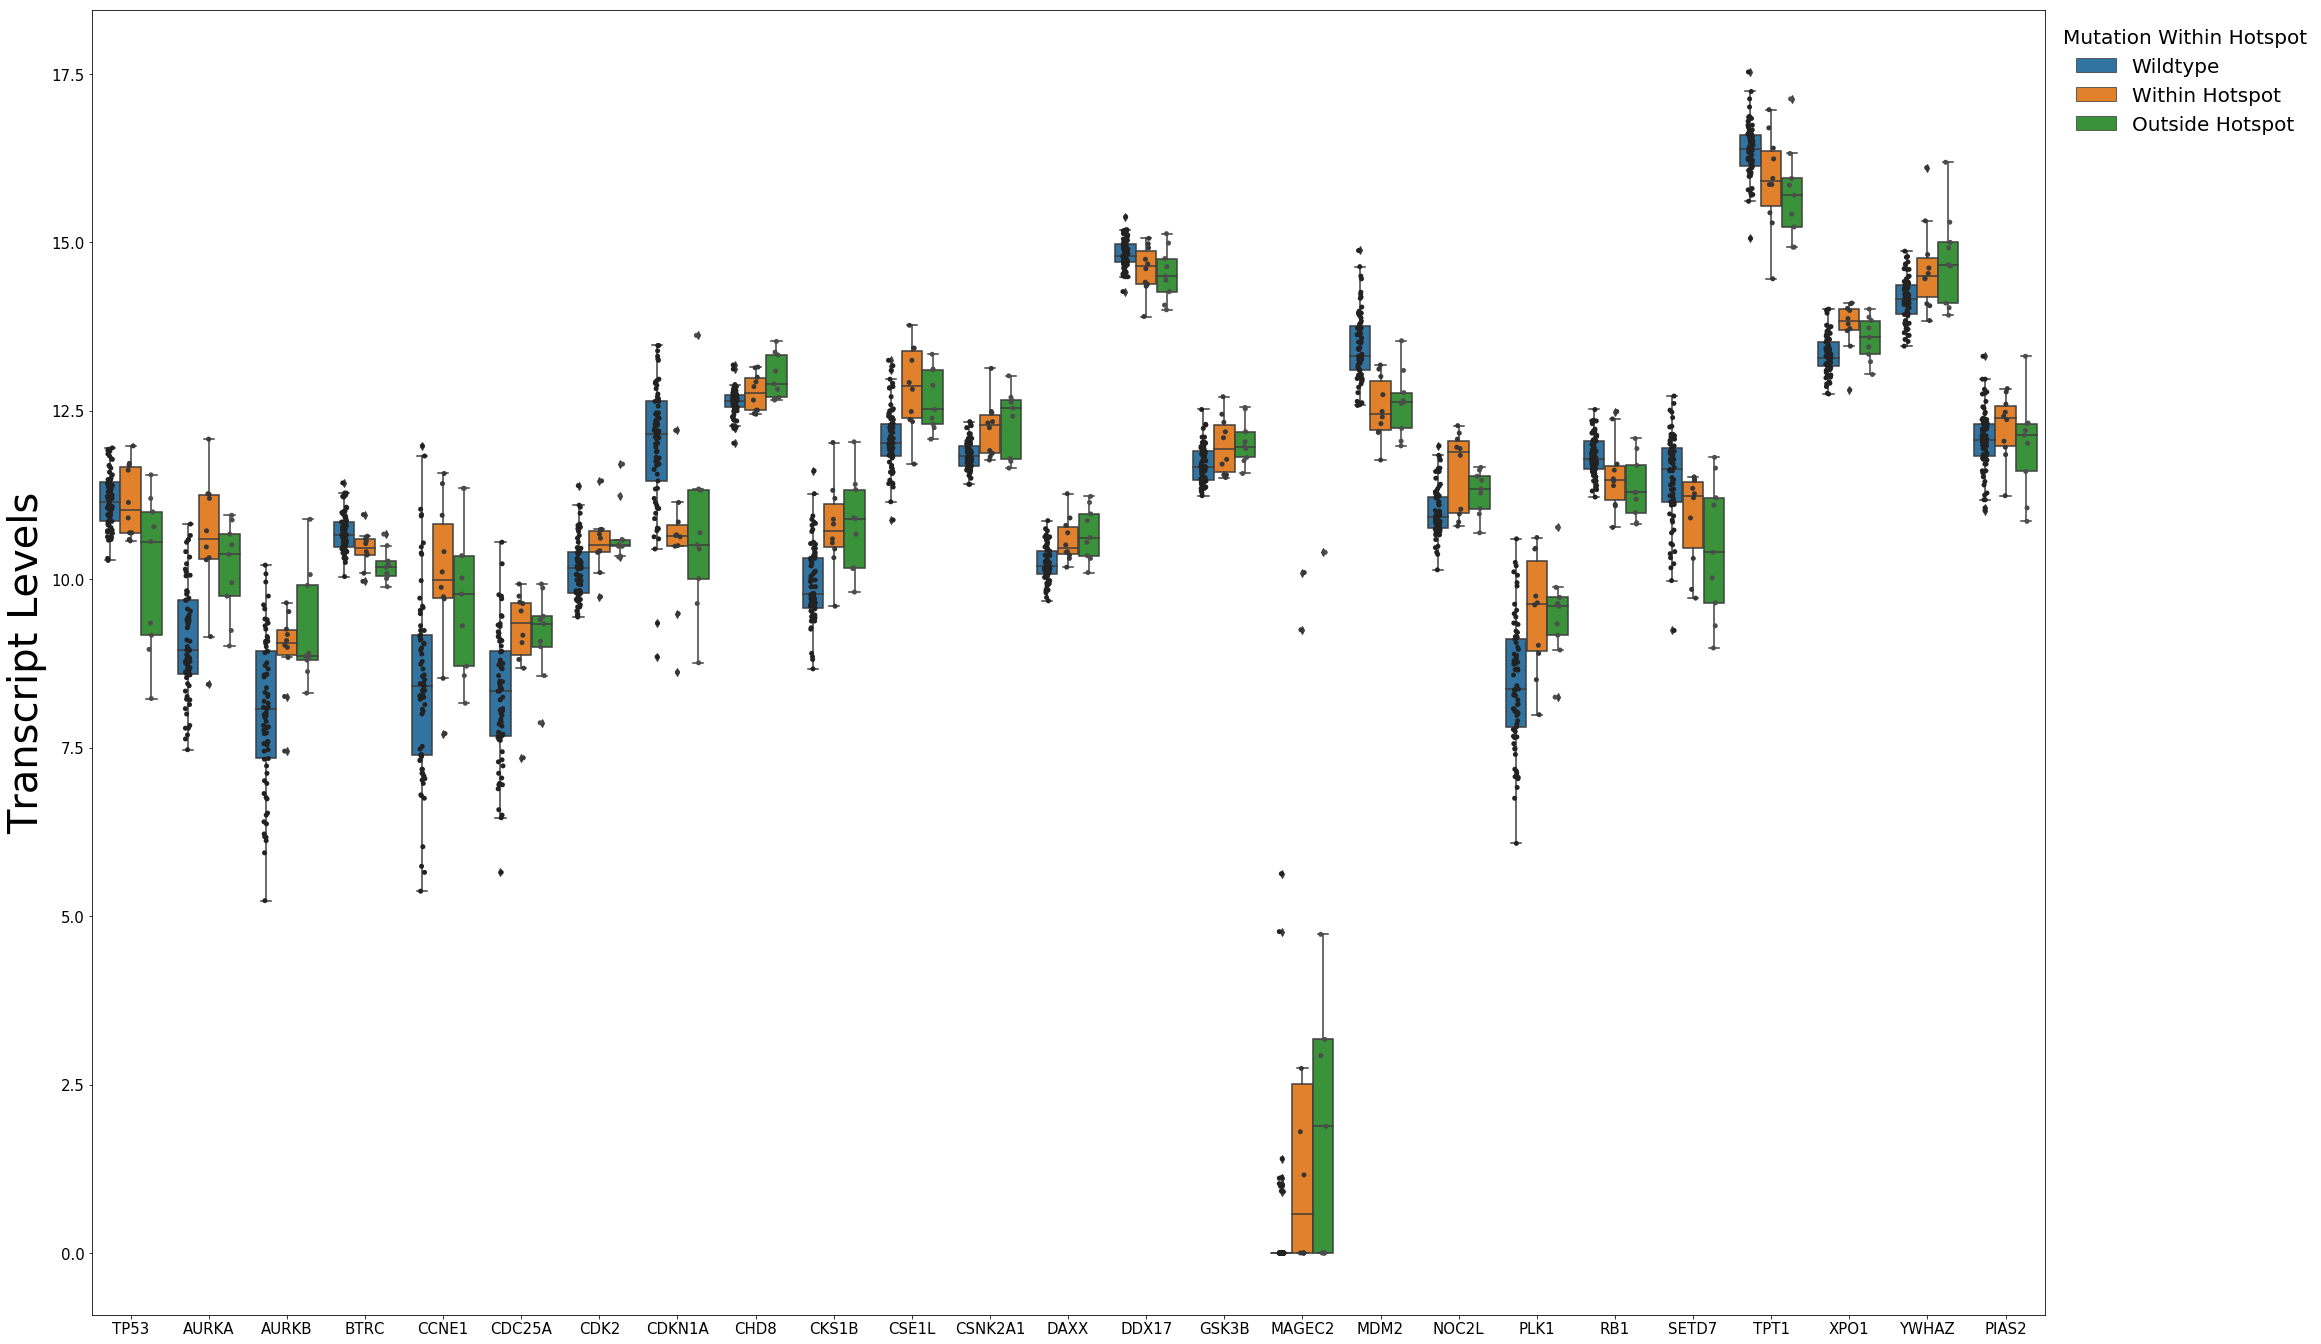

In [36]:
proteins_to_plot = []
for k, v in significant_all_mut_wt.items():
    proteins_to_plot.append(k)

# Add the one where mutation location makes a difference
proteins_to_plot.append('PIAS2')

plotdf = CPTAC.compare_mutations(transcriptomics, gene)
plotdf = plotdf.loc[plotdf['Sample_Status'] == 'Tumor'][[gene, 'Mutation']]
for protein in proteins_to_plot:
    proteindf = CPTAC.compare_mutations(transcriptomics, protein, gene)[[protein]]
    plotdf = plotdf.join(proteindf)

plotdf['Within_Hotspot'] = 'Outside Hotspot'
plotdf.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
plotdf.loc[plotdf['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
plotdf = pd.melt(plotdf, id_vars = ['Mutation', 'Within_Hotspot'], var_name = 'Protein', value_name = 'Transcriptomics')
plotdf = plotdf.dropna(axis = 0)

a4_dims = (35, 24)
fig, ax = plt.subplots(figsize=a4_dims)

#Create the plot
boxplt = sns.boxplot(x='Protein', y='Transcriptomics', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Transcriptomics', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Transcript Levels', fontsize='40')
boxplt.tick_params(labelsize='15')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], title='Mutation Within Hotspot', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))

Within hotspot vs. all other samples: 3.7013584904492115e-05
All mutation vs. wildtype: 9.201478798997596e-07


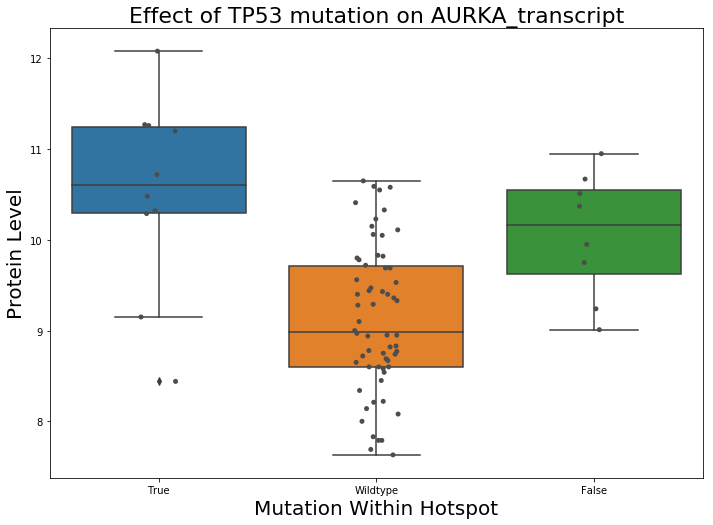

In [33]:
gene = 'TP53'
protein = 'AURKA'

# 1. Get the mutation data as before with the CPTAC package, create the within_hotspot column
p53_transcript_mut = CPTAC.compare_mutations(proteomics, gene)
p53_transcript_mut['Within_Hotspot'] = False
p53_transcript_mut.loc[hotspot_patients, 'Within_Hotspot'] = True
p53_transcript_mut.loc[p53_transcript_mut['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_transcript_mut = p53_transcript_mut.loc[p53_transcript_mut['Sample_Status'] == 'Tumor'].dropna(axis=0)

# 2. Add the transcriptomics data
prot_transcript = pd.DataFrame(transcriptomics[protein])
prot_transcript.columns = [protein + '_transcript']
protein = protein + '_transcript'

transcript_analysis = p53_transcript_mut.join(prot_transcript).drop(gene, axis=1).dropna(axis=0)
transcript_analysis = transcript_analysis.loc[transcript_analysis['Sample_Status'] == 'Tumor']

# 3. Perform t-tests
in_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] == True]
outside_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] != True]
htspt_ttest = scipy.stats.ttest_ind(in_hotspot[protein], outside_hotspot[protein])
print("Within hotspot vs. all other samples: " + str(htspt_ttest[1]))
mutated_all = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] != 'Wildtype']
wt_all = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] == 'Wildtype']
all_ttest = scipy.stats.ttest_ind(mutated_all[protein], wt_all[protein])
print("All mutation vs. wildtype: " + str(all_ttest[1]))

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = transcript_analysis, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = transcript_analysis, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein, fontsize='22')
plt.show()

# Comparison of Transcriptomic data and Proteomic data

### All Mutations vs. Wildtype

In [45]:
proteomics_all_mut_wt_tstat = {}
transcriptomics_all_mut_wt_tstat = {}
pcutoff = 0.05 / len(interProtList)

for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in proteomics.columns:
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest
        mutated_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
        wt_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated_tp53[protein], wt_tp53[protein])
        if ttest[1] <= pcutoff:
            proteomics_all_mut_wt_tstat[protein] = ttest[0]
            
for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in transcriptomics.columns:
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(transcriptomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest
        mutated_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
        wt_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated_tp53[protein], wt_tp53[protein])
        if ttest[1] <= pcutoff:
            transcriptomics_all_mut_wt_tstat[protein] = ttest[0]
        
proteomics_shared_tstat = {}
transcriptomics_shared_tstat = {}

for protein in proteomics_all_mut_wt_tstat:
    if protein in transcriptomics_all_mut_wt_tstat:
        proteomics_shared_tstat[protein] = proteomics_all_mut_wt_tstat[protein]
        transcriptomics_shared_tstat[protein] = transcriptomics_all_mut_wt_tstat[protein]
    
transcriptomics_shared_tstat

{'AURKA': 5.866110979625483,
 'AURKB': 3.8424162811566838,
 'CHD8': 4.44161596807808,
 'CSE1L': 5.402486879286059,
 'DAXX': 5.551628896552229,
 'PLK1': 4.40463916067155,
 'XPO1': 4.3694509994659985}

In [46]:
proteomics_shared_tstat

{'AURKA': 4.516151943810517,
 'AURKB': 4.025603454556902,
 'CHD8': 4.365633574908367,
 'CSE1L': 5.401747167638314,
 'DAXX': 4.197609155092577,
 'PLK1': 4.207271113809839,
 'XPO1': 5.667695104485602}

### Non-Hotspot vs. Wildtype

In [54]:
proteomics_nonhs_wt_tstat = {}
transcriptomics_nonhs_wt_tstat = {}
pcutoff = 0.05 / len(interProtList)

for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in proteomics.columns:
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == False]
        wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if ttest[1] <= pcutoff:
            proteomics_nonhs_wt_tstat[protein] = ttest[0]
            
for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in transcriptomics.columns:
        p53_mutations_protein = CPTAC.compare_mutations(transcriptomics, protein, gene)
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == False]
        wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if ttest[1] <= pcutoff:
            transcriptomics_nonhs_wt_tstat[protein] = ttest[0]
        
proteomics_shared_tstat = {}
transcriptomics_shared_tstat = {}

for protein in proteomics_nonhs_wt_tstat:
    if protein in transcriptomics_nonhs_wt_tstat:
        proteomics_shared_tstat[protein] = proteomics_nonhs_wt_tstat[protein]
        transcriptomics_shared_tstat[protein] = transcriptomics_nonhs_wt_tstat[protein]

proteomics_shared_tstat

{'CHD8': 4.4435806856212015}

In [55]:
transcriptomics_shared_tstat

{'CHD8': 5.158630450453913}

### Hotspot vs. Wildtype

In [52]:
proteomics_htspt_wt_tstat = {}
transcriptomics_htspt_wt_tstat = {}
pcutoff = 0.05 / len(interProtList)

for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in proteomics.columns:
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest
        hotspot_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
        other_mut_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(hotspot_tp53) < 2 or len(other_mut_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(hotspot_tp53[protein], other_mut_tp53[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            proteomics_htspt_wt_tstat[protein] = ttest[0]
            
for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in transcriptomics.columns:
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(transcriptomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest
        hotspot_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
        other_mut_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(hotspot_tp53) < 2 or len(other_mut_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(hotspot_tp53[protein], other_mut_tp53[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            transcriptomics_htspt_wt_tstat[protein] = ttest[0]
        
proteomics_shared_tstat = {}
transcriptomics_shared_tstat = {}

for protein in proteomics_htspt_wt_tstat:
    if protein in transcriptomics_htspt_wt_tstat:
        proteomics_shared_tstat[protein] = proteomics_htspt_wt_tstat[protein]
        transcriptomics_shared_tstat[protein] = transcriptomics_htspt_wt_tstat[protein]

proteomics_shared_tstat

{'AURKA': 5.726277340642757,
 'CSE1L': 4.200504464536369,
 'XPO1': 4.567858513862131}

In [53]:
transcriptomics_shared_tstat

{'AURKA': 5.04423509098076,
 'CSE1L': 4.626510048981035,
 'XPO1': 4.2469470217267675}